In [1]:
import pandas as pd
import numpy as np
import re
import torch
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import os
import random
import shutil

#### 1. Exploratory Data Analysis.

In [2]:
dataset_path = "/content/data_folder-20230501T025224Z-001.zip"

with zipfile.ZipFile(dataset_path, 'r') as zip_file:
  zip_file.extractall('.')

Label distribution: {'angry': 100, 'fear': 100, 'happy': 100, 'sad': 100}


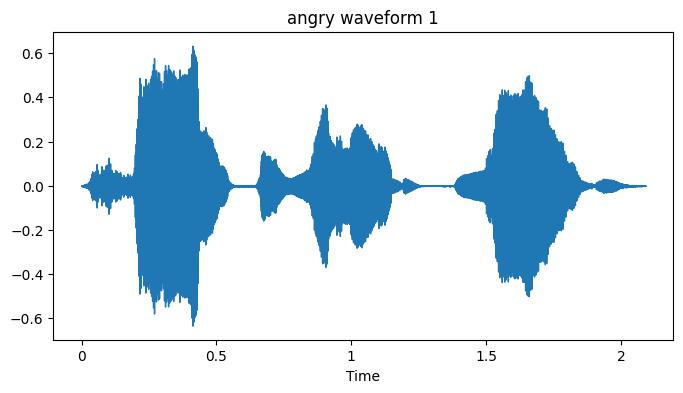

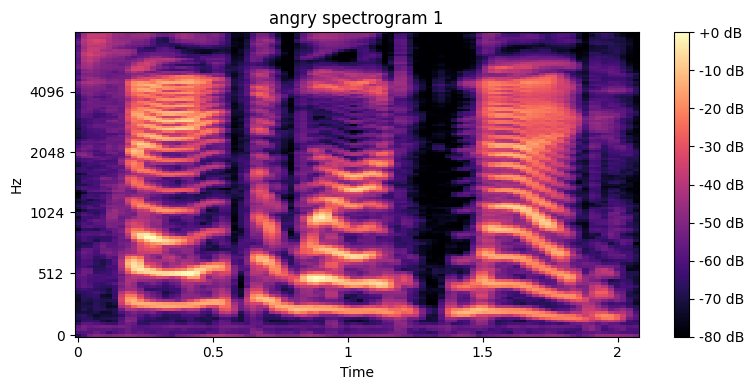

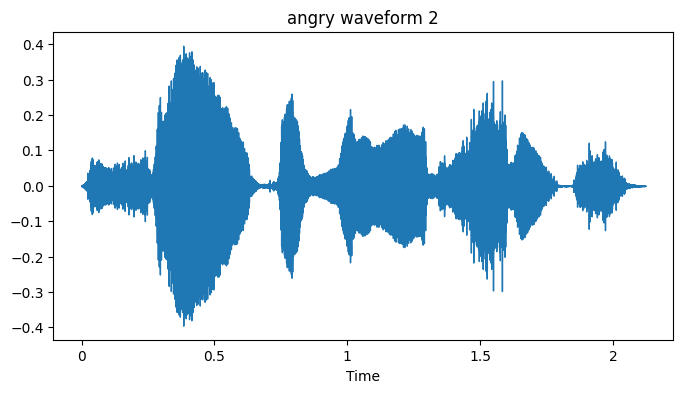

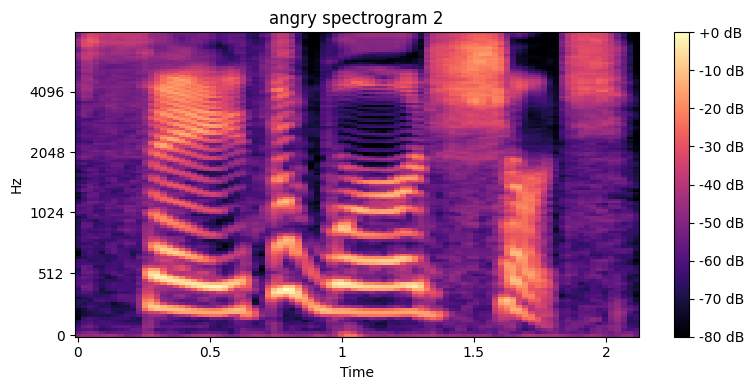

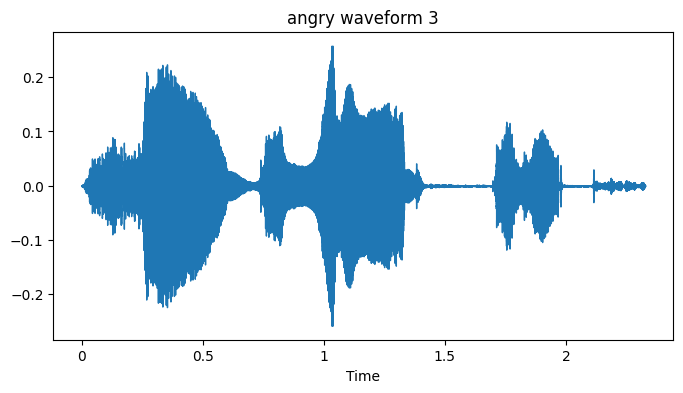

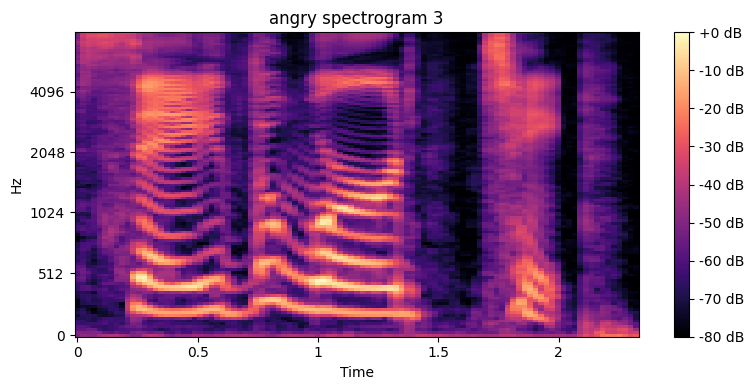

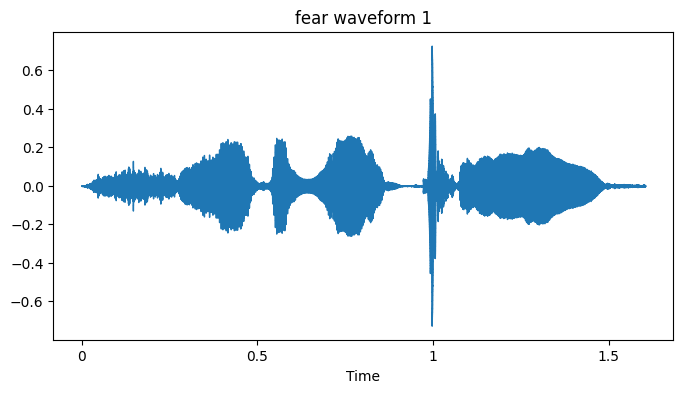

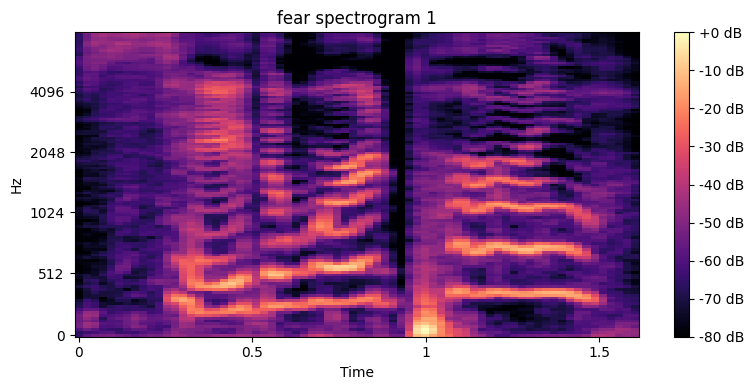

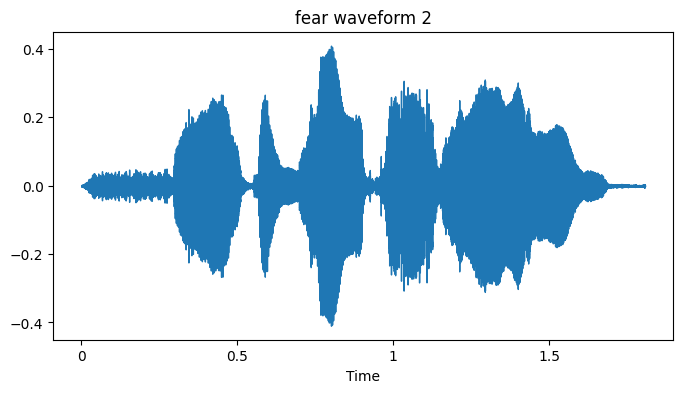

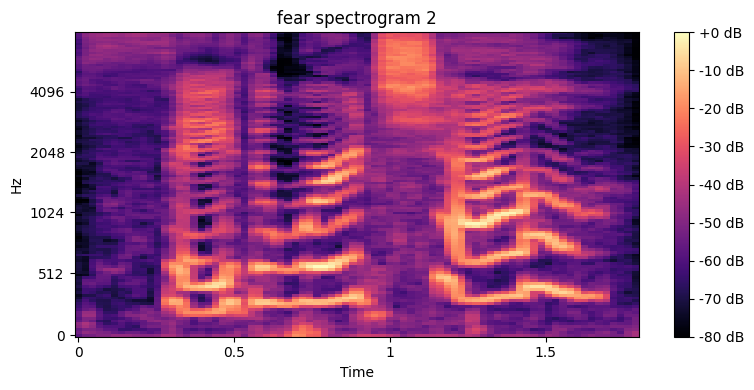

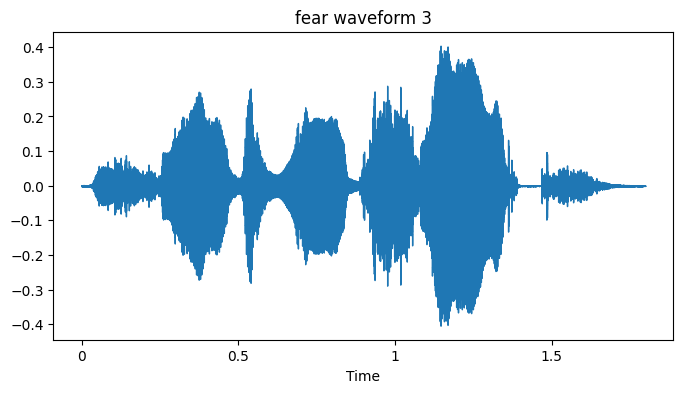

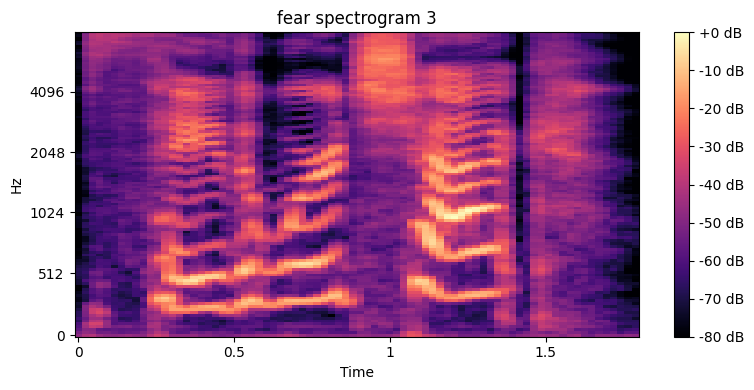

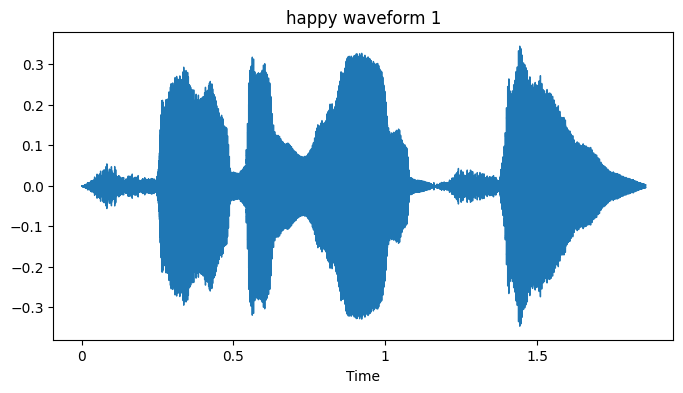

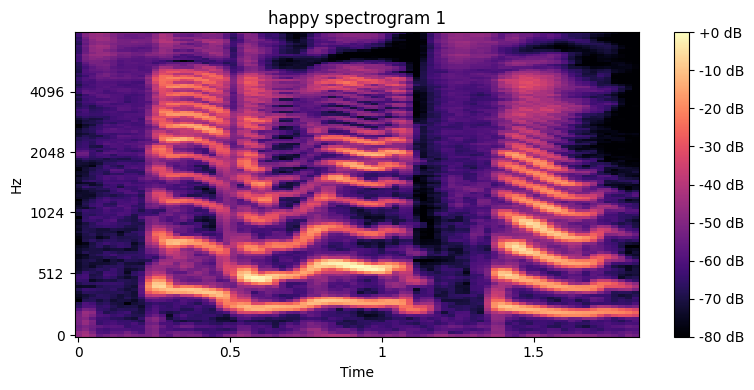

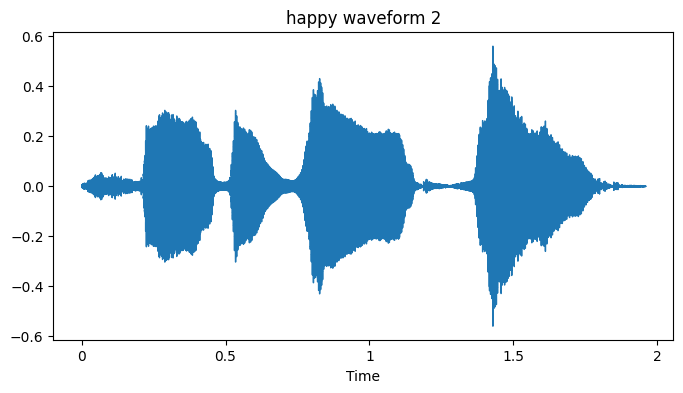

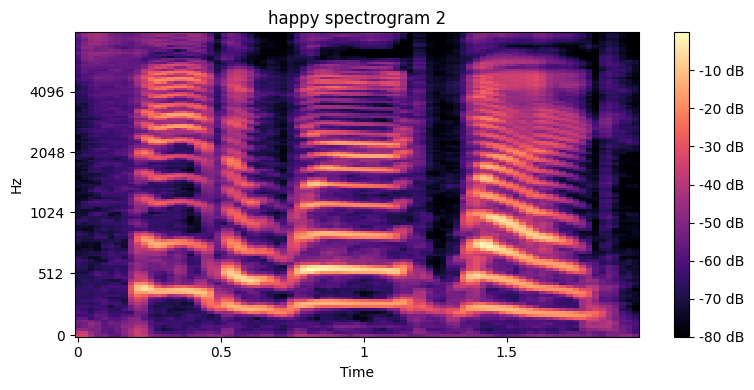

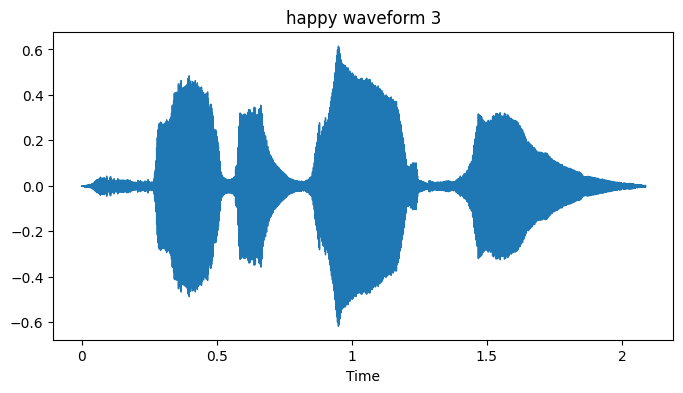

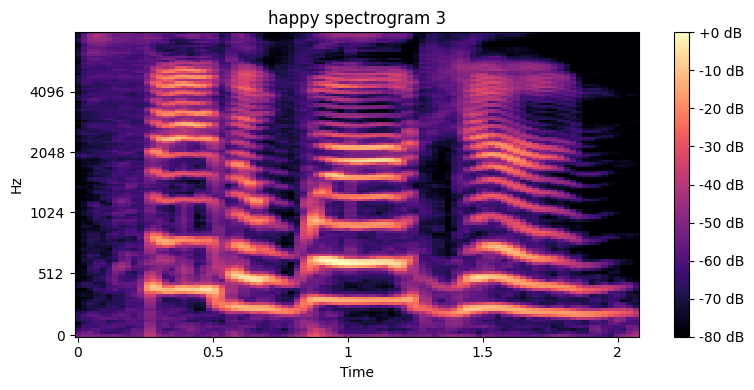

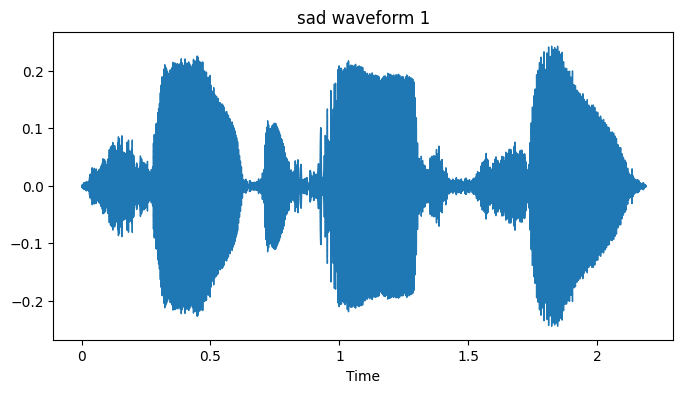

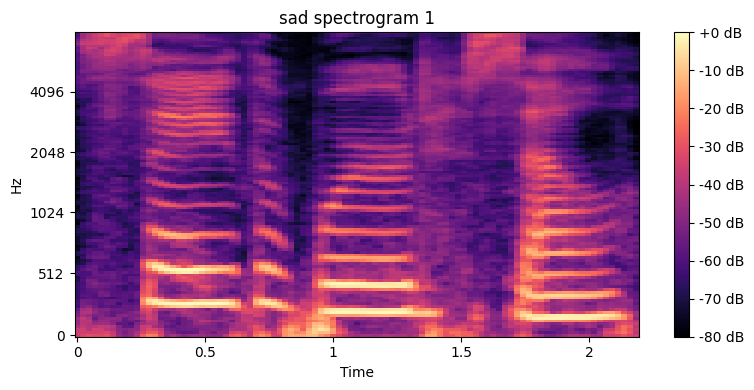

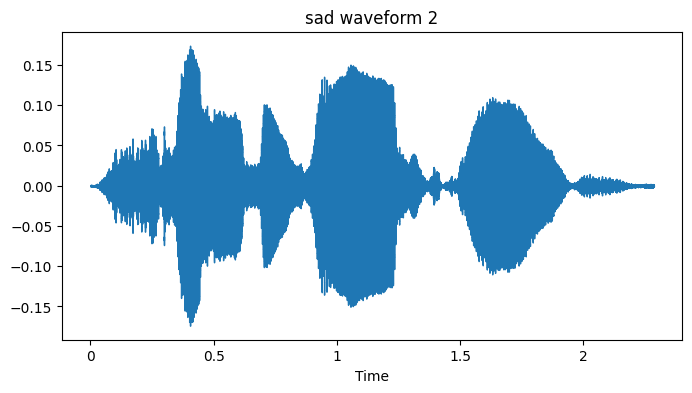

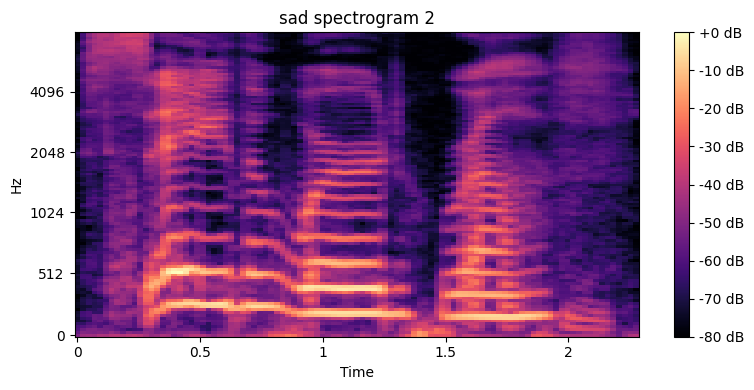

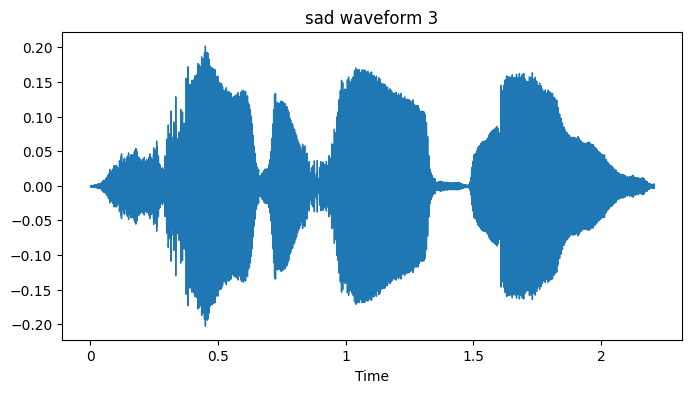

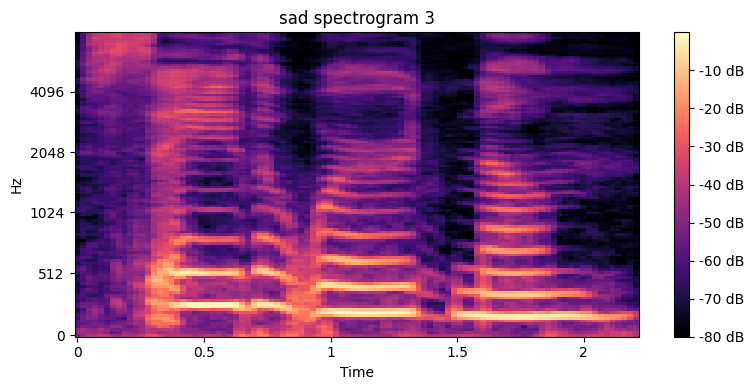

In [3]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt

# For the exploratory data analysis, I used librosa to plot the waveform and spectrogram for each emotion category.
# I drew inspiration from the librosa documentation for the below code, as I was previously unfamiliar with how
# this package worked. 
# We must have a list of all classes in the dataset, as well as the filenames and labels that will be used
# to plot the graphs.
# To check the label distribution, we can simply use the labels that we extracted and loop through each emotion. 

dataset_dir = '/content/data_folder'
emotions = ['angry', 'fear', 'happy', 'sad']

# Create empty lists to store the audio filenames and labels
audio_filenames = []
labels = []

for emotion in emotions:
    audio_files = os.listdir(os.path.join(dataset_dir, emotion))
    audio_filenames.extend(audio_files)
    labels.extend([emotion]*len(audio_files))

# Check label distribution.
label_counts = dict(zip(emotions, [labels.count(emotion) for emotion in emotions]))
print('Label distribution:', label_counts)

# Split the dataset into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    audio_filenames, labels, train_size=0.7, stratify=labels)

# Define the number of samples to show for each emotion
num_samples = 3

# Plot the waveform and spectrogram for each emotion category
for emotion in emotions:
    # Select a random sample from the current emotion category
    indices = [i for i, label in enumerate(train_labels) if label == emotion]
    sample_indices = np.random.choice(indices, size=num_samples, replace=False)
    
    for i, index in enumerate(sample_indices):
        # Load the audio file
        filename = train_filenames[index]
        filepath = os.path.join(dataset_dir, emotion, filename)
        y, sr = librosa.load(filepath)
        
        # Plot the waveform
        plt.figure(figsize=(8, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.title(emotion + ' waveform ' + str(i+1))
        plt.show()
        
        # Plot the spectrogram
        plt.figure(figsize=(8, 4))
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                                 y_axis='mel', fmax=8000, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(emotion + ' spectrogram ' + str(i+1))
        plt.tight_layout()
        plt.show()

#### 2. Data split.

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# For the data split, we want to first have a list of all of the present classes, as well as the directory of the dataset
# and the corresponding ratio of training to testing samples. In accordance with the requirements of the assignment, we have a 
# training ratio of 0.7, which would leave 30% of the data to the testing set. 
# We must save the training and test sets separately, which is why I used 'os' to create a path where the train and test folders
# would be created after the data split.

dataset_dir = '/content/data_folder'
emotions = ['angry', 'fear', 'happy', 'sad']
train_ratio = 0.7

# Define the directory to save the training and testing sets
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [5]:
# We must loop through each emotion category and copy files to appropriate directories.
# Using train_test_split, we will split the files into training and test set in the for-loop for each
# emotion.
# Afterwards, we copy the corresponding files to the train and test directories using the remaining two for-loops. 

for emotion in emotions:
    # Get a list of all audio files for the current emotion.
    audio_files = os.listdir(os.path.join(dataset_dir, emotion))
    # Split the files into training and testing sets.
    np.random.seed(42)
    train_files, test_files = train_test_split(audio_files, train_size=train_ratio, random_state=42)
    for filename in train_files:
        src = os.path.join(dataset_dir, emotion, filename)
        dst = os.path.join(train_dir, emotion, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)
    for filename in test_files:
        src = os.path.join(dataset_dir, emotion, filename)
        dst = os.path.join(test_dir, emotion, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

#### 3. Acoustic Feature Extraction.

In [17]:
split_dir_train = '/content/train'
split_dir_test = '/content/test'
dataset_dir = '/content/data_folder'

# For feature extraction, we want to define a path where we want the extracted features to be stored.
# Using various for-loops, we 'loop' through each class and extract the features for each individual one. 
# We once again use the librosa tool to perform tasks such as extracting the Mel-frequency cepstral coefficients.
# Define the directory to save the extracted features
feature_dir = '/content/features2'

# Loop through each emotion category and extract features for all audio files
for emotion in emotions:
    # Get a list of all audio files for the current emotion in the training set
    train_files = os.listdir(os.path.join(split_dir_train, emotion))
    for audio_file in train_files:
        # Load the audio file
        audio_path = os.path.join(split_dir_train, emotion, audio_file)
        y, sr = librosa.load(audio_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        # Compute the logarithm of the mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_S = librosa.amplitude_to_db(S, ref=np.max)
        # Save the features to a file
        feature_file = os.path.splitext(audio_file)[0] + '.npy'
        os.makedirs(os.path.join(feature_dir, 'train', emotion), exist_ok=True)
        np.save(os.path.join(feature_dir, 'train', emotion, feature_file), log_S)
        np.save(os.path.join(feature_dir, 'train', emotion, 'mfcc_' + feature_file), mfccs)
        
    # Get a list of all audio files for the current emotion in the test set
    test_files = os.listdir(os.path.join(split_dir_test, emotion))
    for audio_file in test_files:
        # Load the audio file
        audio_path = os.path.join(split_dir_test, emotion, audio_file)
        y, sr = librosa.load(audio_path, sr=22050)
        # Extract Mel-frequency cepstral coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        # Compute the logarithm of the mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_S = librosa.amplitude_to_db(S, ref=np.max)
        # Save the features to a file
        feature_file = os.path.splitext(audio_file)[0] + '.npy'
        os.makedirs(os.path.join(feature_dir, 'test', emotion), exist_ok=True)
        np.save(os.path.join(feature_dir, 'test', emotion, feature_file), log_S)
        np.save(os.path.join(feature_dir, 'test', emotion, 'mfcc_' + feature_file), mfccs)

#### 4. Feature post-processing.

In [ ]:
feature_dir = '/content/features2/train'

# For feature post-processing, we focus on computing the mean and standard deviation of each feature across all of the
# classes, which will then be used to normalize these very same features. 
# We first load all features for each emotion and concatenate them into a single array.
for emotion in emotions:
    feature_files = os.listdir(os.path.join(feature_dir, emotion))
    features = []
    for feature_file in feature_files:
        feature_path = os.path.join(feature_dir, emotion, feature_file)
        feature = np.load(feature_path)
        features.append(feature)
    # Compute the mean and standard deviation of each feature across all audio files.
    mean = np.mean(features, axis=1)
    std = np.std(features, axis=1)
    # Normalize each feature using its mean and standard deviation.
    for feature_file in feature_files:
        feature_path = os.path.join(feature_dir, emotion, feature_file)
        feature = np.load(feature_path)
        normalized_feature = (feature - mean[:, np.newaxis]) / std[:, np.newaxis]

#### 5. Audio recognition model.

In [102]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Define the directory where the features are saved
feature_dir = '/content/features2'

# We want to train an SVM model here, which requires us to load the features and labels for the normalized data.

X_train = []
y_train = []
for i, emotion in enumerate(emotions):
    train_files = os.listdir(os.path.join(feature_dir, 'train', emotion))
    for audio_file in train_files:
        feature_file = os.path.join(feature_dir, 'train', emotion, audio_file)
        log_S = np.load(feature_file)
        mfcc_file = os.path.join(feature_dir, 'train', emotion,audio_file)
        mfccs = np.load(mfcc_file)
        # Concatenate the features into a single array
        features = np.concatenate((log_S.flatten(), mfccs.flatten()))
        X_train.append(features)
        y_train.append(i)

# Convert the lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the SVM model
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)

# Evaluate the model on the validation set
val_acc = svm.score(X_val, y_val)
print('Accuracy for SVM:', val_acc)

Accuracy for SVM: 0.6


#### 6. Model evaluation.

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

feature_dir = '/content/features2'

# We perform the same process for other models to compare their performance with SVM. 


X_train = []
y_train = []
for i, emotion in enumerate(emotions):
    train_files = os.listdir(os.path.join(feature_dir, 'train', emotion))
    for audio_file in train_files:
        feature_file = os.path.join(feature_dir, 'train', emotion, audio_file)
        log_S = np.load(feature_file)
        mfcc_file = os.path.join(feature_dir, 'train', emotion,audio_file)
        mfccs = np.load(mfcc_file)
        # Concatenate the features into a single array
        features = np.concatenate((log_S.flatten(), mfccs.flatten()))
        X_train.append(features)
        y_train.append(i)

# Convert the lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Train the SVM model
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)

# Evaluate the model on the validation set
val_acc = svm.score(X_val, y_val)
y_pred = svm.predict(X_val)
print('Accuracy for SVM:', val_acc)
print('Classification report for SVM:')
print(classification_report(y_val, y_pred, target_names=emotions))


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


val_acc = knn.score(X_val, y_val)
y_pred = knn.predict(X_val)
print('Accuracy for K-Nearest Neighbors:', val_acc)
print('Classification report for K-Nearest Neighbors:')
print(classification_report(y_val, y_pred, target_names=emotions))


dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

val_acc = dt.score(X_val, y_val)
y_pred = dt.predict(X_val)
print('Accuracy for Decision Tree:', val_acc)
print('Classification report for Decision Tree:')
print(classification_report(y_val, y_pred, target_names=emotions))


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


val_acc = rf.score(X_val, y_val)
y_pred = rf.predict(X_val)
print('Accuracy for Random Forest:', val_acc)
print('Classification report for Random Forest:')
print(classification_report(y_val, y_pred, target_names=emotions))

Accuracy for SVM: 0.55
Classification report for SVM:
              precision    recall  f1-score   support

       angry       0.50      0.56      0.53         9
        fear       0.60      0.55      0.57        11

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20

Accuracy for K-Nearest Neighbors: 0.55
Classification report for K-Nearest Neighbors:
              precision    recall  f1-score   support

       angry       0.50      0.67      0.57         9
        fear       0.62      0.45      0.53        11

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20

Accuracy for Decision Tree: 0.5
Classification report for Decision Tree:
              precision    recall  f1-score   support

       angry       0.44      0.44      0.44         9
        fear       0.55 